# Importación de librerías y lectura del Data Frame

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
!pip install category_encoders
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error, roc_auc_score
import seaborn as sns

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df_secundario = pd.read_csv("/content/drive/MyDrive/secondary_data.csv", delimiter=';')

# Exploración de los datos

Al igual que en la parte 3, no se van a utilizar todas las columnas y se van a ir probando de a poco hasta alcanzar buenos resultados. Por enunciado si o si debo tener por lo menos 40 features numéricas.


Elimino las columnas que no voy a usar.

In [ ]:
df_secundario = df_secundario.drop("stem-root", axis = 1)
df_secundario = df_secundario.drop("stem-surface", axis = 1)
df_secundario = df_secundario.drop("veil-type", axis = 1)
df_secundario = df_secundario.drop("veil-color", axis = 1)
df_secundario = df_secundario.drop("spore-print-color", axis = 1)
df_secundario = df_secundario.drop("season", axis = 1)
df_secundario = df_secundario.drop("does-bruise-or-bleed", axis = 1)

In [ ]:
# Imputa los Nans dedos un df, la nombre de la features y un caracter.
def imputar_nans(df, nombre_feature, caracter):

  df[nombre_feature] = df[nombre_feature].fillna(caracter)

In [ ]:
#Reemplaza la d por o en esta categoria.
df_secundario['cap-surface'] = df_secundario["cap-surface"].map(lambda x: 'o' if x == 'd' else x)

In [ ]:
imputar_nans(df_secundario, 'cap-surface', 'o')
imputar_nans(df_secundario, 'gill-attachment', 'o')
imputar_nans(df_secundario, 'gill-spacing', 'o')
imputar_nans(df_secundario, 'ring-type', 'o')

# Preparación de los datos

En esta sección se preparan los datos para realizar un XGBoost de clasificación.


Separo el target del resto del Data Frame.

In [ ]:
X = df_secundario.drop('class', axis=1)

In [ ]:
y = df_secundario['class']

Creo un set de entrenamiento y uno de medición.

In [ ]:
X_train, X_med, y_train, y_med = train_test_split(X, y, test_size=0.2, random_state=13)

Creo un set de testeo y uno de validación a partir del de medición.

In [ ]:
X_test, X_validation, y_test, y_validation = train_test_split(X_med, y_med, test_size=0.5, random_state=13)

Voy a utilizar una variable binaria {0, 1} para representar al target ("class") en donde 1 es para indicar que el hongo es venenoso ('p') y 0 si el hongo es comestible ('e').

In [ ]:
y_train =  y_train.map(lambda x: 1 if x == 'p' else 0)

In [ ]:
y_validation =  y_validation.map(lambda x: 1 if x == 'p' else 0)

In [ ]:
y_test =  y_test.map(lambda x: 1 if x == 'p' else 0)

Aplico un encoding a todas las columnas. Por enunciado, necesito aplicar mean coding y OHE por lo menos una vez.

In [ ]:
#Aplica OHE a cada columna dada una feature.
def aplicar_ohe(nombre_feature, columnas):

  global X_train, X_test, X_validation
  ohe = OneHotEncoder()
  encoded_train = ohe.fit_transform(X_train[[nombre_feature]]).todense().astype(int)
  encoded_test = ohe.fit_transform(X_test[[nombre_feature]]).todense().astype(int)
  encoded_validation = ohe.transform(X_validation[[nombre_feature]]).todense().astype(int)
  X_train = X_train.reset_index().drop(['index', nombre_feature],axis=1).join(pd.DataFrame(encoded_train))
  X_test = X_test.reset_index().drop(['index', nombre_feature],axis=1).join(pd.DataFrame(encoded_test))
  X_validation = X_validation.reset_index().drop(['index', nombre_feature],axis=1).join(pd.DataFrame(encoded_validation))
  X_train = X_train.rename(columns=columnas)
  X_test = X_test.rename(columns=columnas)
  X_validation = X_validation.rename(columns=columnas)

In [ ]:
#Aplica Mean encoding por cada columa.
def aplicar_mean_encoding(nombre_feature):

  global X_train, X_test, X_validation
  encoder = TargetEncoder()
  X_train[nombre_feature+ "-mean"] = encoder.fit_transform(X_train[nombre_feature], y_train)
  X_test[nombre_feature+ "-mean"] = encoder.transform(X_test[nombre_feature], y_test)
  X_validation[nombre_feature+ "-mean"] = encoder.transform(X_validation[nombre_feature], y_validation)
  X_train = X_train.drop([nombre_feature],axis=1)
  X_test = X_test.drop([nombre_feature],axis=1)
  X_validation = X_validation.drop([nombre_feature],axis=1)


* Aplicación de Mean Encoding.


Con "cap-surface":

In [ ]:
aplicar_mean_encoding('cap-surface')

Con "gill-spacing":

In [ ]:
aplicar_mean_encoding('gill-spacing')

Con "ring-type":

In [ ]:
aplicar_mean_encoding('ring-type')

Con "habitat":

In [ ]:
aplicar_mean_encoding('habitat')

* Aplicación de OHE.

Con "cap-shape":

In [ ]:
aplicar_ohe('cap-shape', {0:'b0',1:'c0',2:'f0',3:'o0',4:'p0',5:'s0',6:'x0'})

Con "cap-color":

In [ ]:
aplicar_ohe('cap-color', {0:'b2',1:'e2',2:'g2',3:'k2',4:'l2',5:'n2',6:'o2', 7:'p2', 8:'r2', 9:'u2', 10:'w2', 11:'y2'})

Con "gill-attachment":

In [ ]:
aplicar_ohe('gill-attachment', {0:'a4',1:'d4',2:'e4',3:'f4',4:'o4',5:'p4',6:'s4', 7:'x4'})

Con "gill-color":

In [ ]:
aplicar_ohe('gill-color', {0:'b6',1:'e6',2:'f6',3:'g6',4:'k6',5:'n6',6:'o6', 7:'p6', 8:'r6', 9:'u6', 10:'w6', 11:'y6'})

Con "stem-color":

In [ ]:
aplicar_ohe('stem-color', {0:'b9',1:'e9',2:'f9',3:'g9',4:'k9',5:'l9',6:'n9', 7:'o9', 8:'p9', 9:'r9', 10:'u9', 11:'w9', 12:'y9'})

Con "has-ring":

In [ ]:
aplicar_ohe('has-ring', {0:'f12',1:'t12'})

In [ ]:
X_train

,cap-diameter,stem-height,stem-width,cap-surface-mean,gill-spacing-mean,ring-type-mean,habitat-mean,b0,c0,f0,...,l9,n9,o9,p9,r9,u9,w9,y9,f12,t12
0,15.74,5.02,28.73,0.925151,0.585689,0.555199,0.544301,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,1.27,3.79,5.63,0.431833,0.603135,0.555199,0.544301,0,0,1,...,0,0,0,0,0,0,0,1,1,0
2,12.05,6.03,23.98,0.479898,0.563700,0.566876,0.544301,0,0,1,...,0,1,0,0,0,0,0,0,0,1
3,8.08,6.04,14.95,0.652791,0.563700,0.423019,0.544301,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,6.44,12.23,12.77,0.473605,0.563700,0.555199,0.544301,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48850,8.53,3.63,25.28,0.529736,0.603135,0.555199,0.544301,0,0,0,...,0,1,0,0,0,0,0,0,1,0
48851,10.66,5.10,19.52,0.521801,0.585689,0.555199,0.544301,0,0,1,...,0,0,0,0,0,0,1,0,0,1
48852,1.62,3.73,2.63,0.830604,0.563700,0.555199,0.686006,0,0,0,...,0,0,0,0,0,0,1,0,1,0
48853,1.29,5.00,2.45,0.529736,0.563700,0.555199,0.686006,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [ ]:
X_validation

,cap-diameter,stem-height,stem-width,cap-surface-mean,gill-spacing-mean,ring-type-mean,habitat-mean,b0,c0,f0,...,l9,n9,o9,p9,r9,u9,w9,y9,f12,t12
0,2.38,8.13,2.59,0.652791,0.585689,0.566876,5.121951e-01,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,2.35,5.48,2.31,0.529736,0.563700,0.555199,5.443006e-01,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,7.70,14.78,18.18,0.479898,0.563700,0.555199,5.443006e-01,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,5.64,6.76,12.15,0.925151,0.585689,0.555199,6.860063e-01,0,1,0,...,0,0,0,0,0,0,1,0,1,0
4,5.69,7.84,14.56,0.652791,0.585689,0.555199,5.443006e-01,0,0,0,...,0,0,0,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,10.65,10.00,22.49,0.529736,0.563700,0.555199,5.443006e-01,0,0,0,...,0,1,0,0,0,0,0,0,1,0
6103,5.20,12.43,13.25,0.652791,0.563700,0.555199,5.443006e-01,0,1,0,...,0,1,0,0,0,0,0,0,1,0
6104,8.51,4.52,13.00,0.479898,0.585689,0.396507,2.322821e-12,0,0,1,...,0,0,0,0,0,0,1,0,0,1
6105,9.27,11.46,32.54,0.652791,0.409751,0.555199,5.443006e-01,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
X_test

,cap-diameter,stem-height,stem-width,cap-surface-mean,gill-spacing-mean,ring-type-mean,habitat-mean,b0,c0,f0,...,l9,n9,o9,p9,r9,u9,w9,y9,f12,t12
0,7.81,6.27,18.18,0.652791,0.585689,0.555199,0.544301,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,10.96,3.89,26.20,0.529736,0.603135,0.555199,0.544301,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,9.27,11.77,18.76,0.830604,0.563700,0.555199,0.544301,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,7.93,7.56,13.68,0.479898,0.563700,0.396507,0.686006,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,9.96,8.33,15.72,0.652791,0.563700,0.423019,0.544301,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6102,13.53,6.19,16.40,0.652791,0.585689,0.555199,0.544301,0,0,1,...,0,1,0,0,0,0,0,0,1,0
6103,3.55,4.84,6.47,0.652791,0.585689,1.000000,0.544301,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6104,4.16,5.16,10.51,0.431833,0.563700,0.555199,0.544301,0,0,0,...,0,1,0,0,0,0,0,0,1,0
6105,4.51,6.44,9.02,0.473605,0.585689,0.566876,0.686006,0,0,0,...,0,1,0,0,0,0,0,0,0,1


# Entrenamiento y validacion del modelo

En esta sección se encuentra el entrenamiento y búsqueda de híper parámetros del modelo mediante los set de entrenamiento y validación.

Entreno un XGboost de clasificación.

In [ ]:
xg_model = xgb.XGBClassifier(random_state = 16)

params = {"learning_rate": [0, 0.1, 0.2, 1],
           "max_depth": [1,3, None],
           "subsample": [0.1, 0.3, 1],
           "n_estimators": [1, 2, 10, 100]}

rs = RandomizedSearchCV(xg_model, param_distributions=params, n_iter=10, random_state=13, scoring='roc_auc')

In [ ]:
rs.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=16, ...),
                   param_distributions={'learning_rate': [0, 0.1, 0.2, 1],
                                        'max_depth': [1, 3, None],
                                        'n_estimators': [1, 2, 10, 100],
                                        'subsample': [0.1, 0.3, 1]},
                   random_state=13, scoring='roc_auc')

In [ ]:
rs.best_params_

{'subsample': 0.3, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 1}

In [ ]:
model = rs.best_estimator_

Entreno el modelo con los mejores parámetros.

In [ ]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=16, ...)

In [ ]:
y_pred_validation = model.predict(X_validation)

In [ ]:
y_pred_validation

array([1, 1, 1, ..., 0, 1, 0])

Realizo una matriz de confusión con el set de validación.

In [ ]:
matriz_confusion_validation = confusion_matrix(y_validation, y_pred_validation)

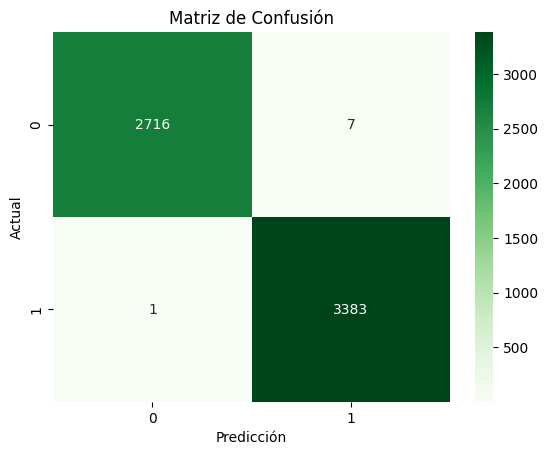

In [ ]:
sns.heatmap(matriz_confusion_validation, annot=True, cmap='Greens', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

Métricas del set de validación

In [ ]:
roc_auc = roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])
print("ROC AUC SCORE:", (roc_auc))

ROC AUC SCORE: 0.9998069374881169


In [ ]:
rmse = np.sqrt(mean_squared_error(y_validation, y_pred_validation))
print("RMSE: %f" % (rmse))

RMSE: 0.036194


# Pruebas realizadas

En esta sección están las pruebas realizados con el set de validación en busca de los híper parámetros.

Pruebas:

* Prueba 1: Con "subsample" = 0.5, "n_estimators" = 4, "max_depth" = "None", "learning_rate" = 1 y los demás parámetros por defecto, con features numéricas, cap-shape, cap-color, cap-surface, habitat, stem-color y season.
ROC AUC SCORE: 0.9520915756592341, RMSE: 0.350442, Matriz de confusión:([[2384,339],[411, 2973]]).

* Prueba 2: Con "subsample" = 0.5, "n_estimators" = 4, "max_depth" = "None", "learning_rate" = 1 y los demás parámetros por defecto, con features numéricas, cap-shape, cap-color, cap-surface, habitat, stem-color, season, gill-spacing y gill-attachment.
ROC AUC SCORE: 0.9862181148416996, RMSE: 0.241102, Matriz de confusión:([[2531,192],[163, 3221]]).

* Prueba 3: Con "subsample" = 0.5, "n_estimators" = 4, "max_depth" = "None", "learning_rate" = 1 y los demás parámetros por defecto, con features numéricas, cap-shape, cap-color, cap-surface, habitat, stem-color, gill-spacing, gill-attac y gill-color:
ROC AUC SCORE: 0.9856791350973104, RMSE: 0.242794, Matriz de confusión: ([[2531,192],[168, 3216]]).

* Prueba 4: Con "subsample" = 0.5, "n_estimators" = 4, "max_depth" = "None", "learning_rate" = 1 y los demás parámetros por defecto, con features numéricas, cap-shape, cap-color, cap-surface, habitat, stem-color, gill-spacing, gill-attachment, gill-color, ring-type y has-ring:
ROC AUC SCORE: 0.9868512925963838, RMSE: 0.214124, Matriz de confusión: ([[2570,153],[127, 3257]]).

* Prueba 5: Con "subsample" = 0.3, "n_estimators" = 100, "max_depth" = 3, "learning_rate" = 1 y los demás parámetros por defecto, con features numéricas, cap-shape, cap-color, cap-surface, habitat, stem-color, gill-spacing, gill-attachment, gill-color, ring-type, has-ring:
ROC AUC SCORE: 0.9985668988191824, RMSE: 0.036194, Matriz de confusión: ([[2716,7],[1, 3383]]).

Si bien es cierto que el modelo no llega a ser igual de bueno que el Random Forest de la parte 3, logra predecir de manera bastante eficaz si un hongo es venenoso o comestible, dando un resultado similar.
Una explicación que le puedo dar a esto es que dada la información del data set, es muy probable que su información pueda moldearse de forma eficaz mediante el uso de árboles de decisión, tal y como sucede con este modelo y el de la parte 3, permitiendo que el entrenamiento de dichos modelos sea efectivo.
Dado que se pide trabajar el modelo hasta conseguir un Auc Roc Score de por lo menos 0.9, decidí mejorarlo un poco  desde la prueba 1, pero no lo suficiente para que sea igual de eficaz que el de la parte 3; esto último me parece importante aclararlo ya que muy probablemente ambas métricas serian iguales si hiciera un par de pruebas más o si hubiera utilizado un encoding similar.


# Importancias de las Features por prueba

En esta sección se encuentra la evolución de la importancia de las features dependiendo de la prueba.
Al igual que en la parte 3, decidi incluirlo mas alla de que no este pedido en el enunciado con la diferencia de que decidi dejar las importancias indiviudales.


Prueba 1

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

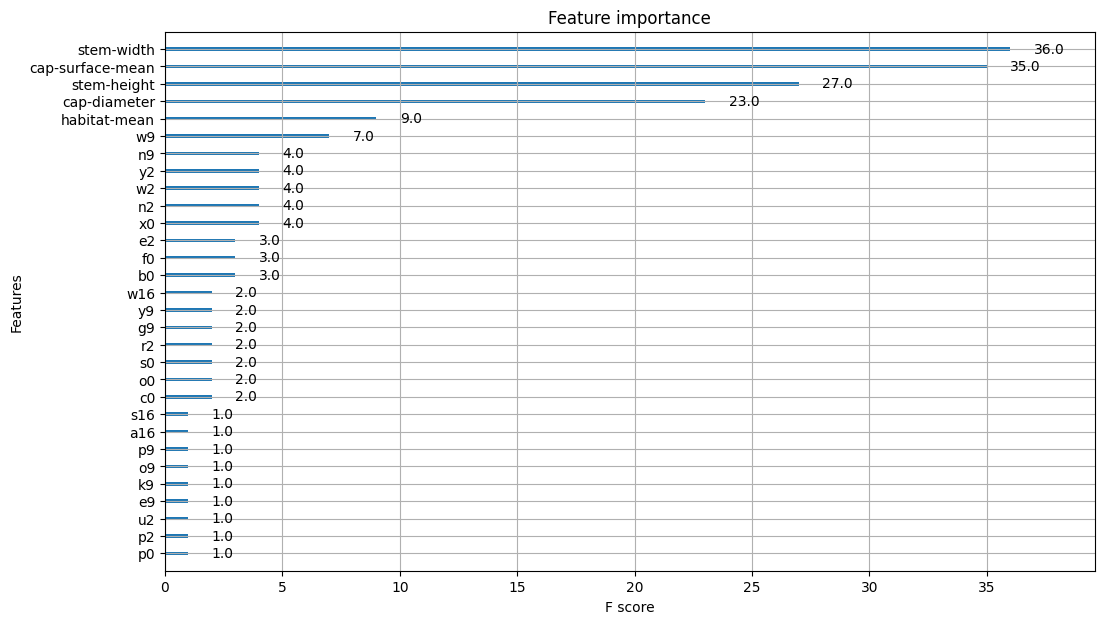

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(model)

Prueba 2

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

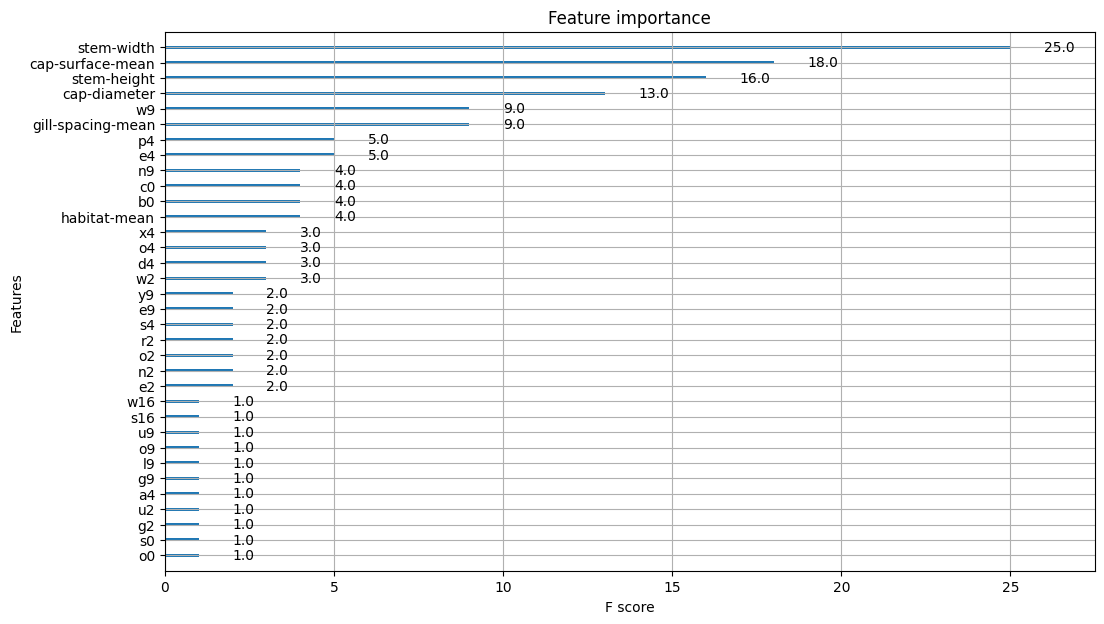

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(model)

Prueba 3

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

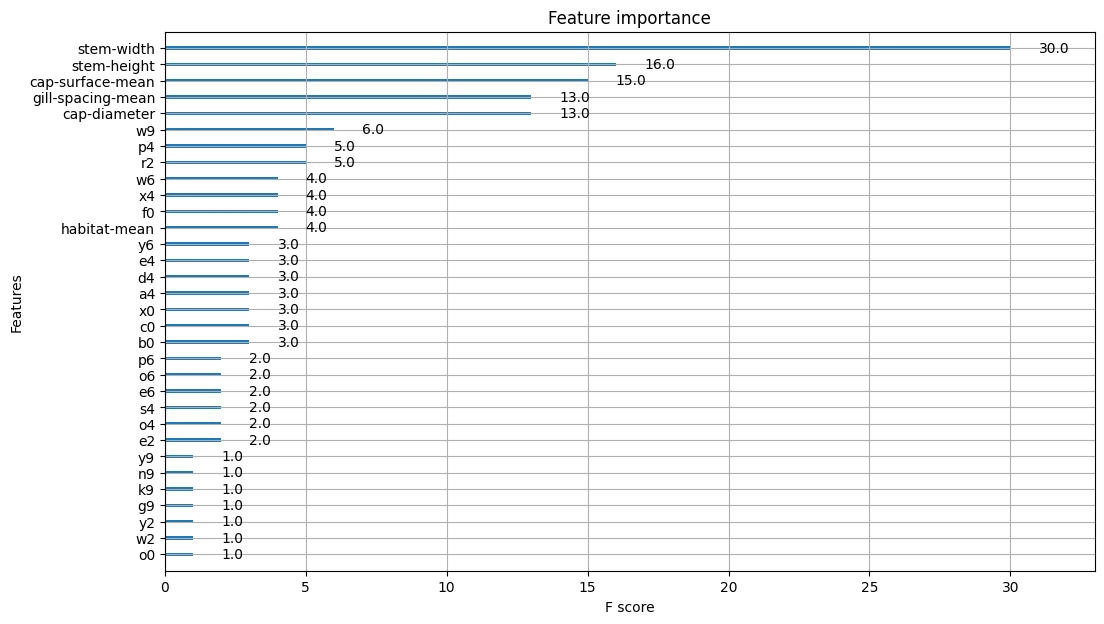

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(model)

Prueba 4

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

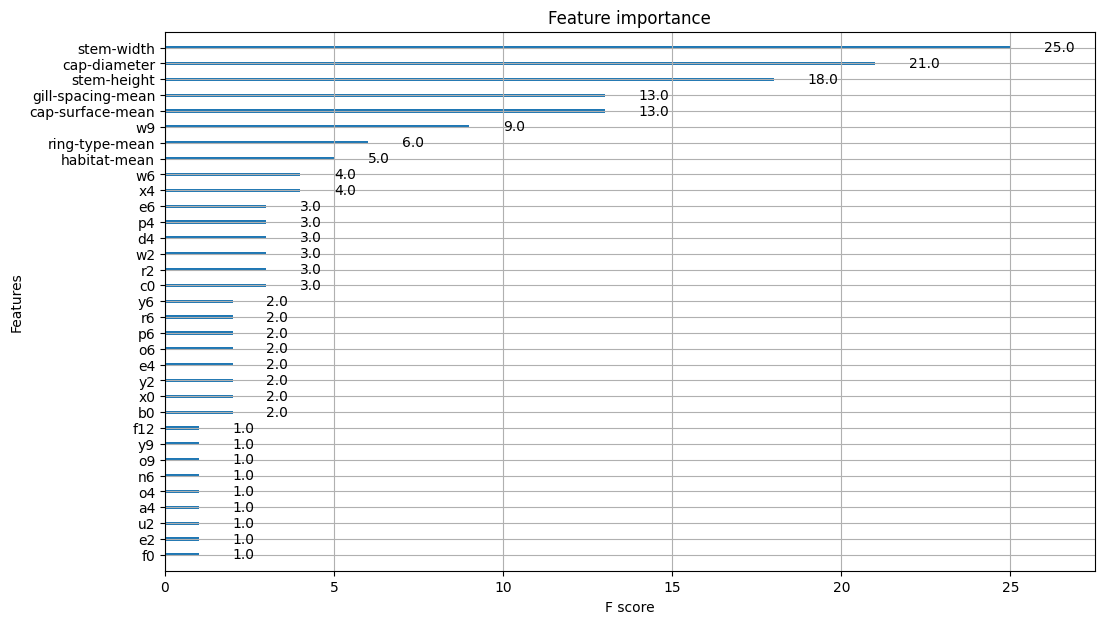

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(model)

Prueba 5

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

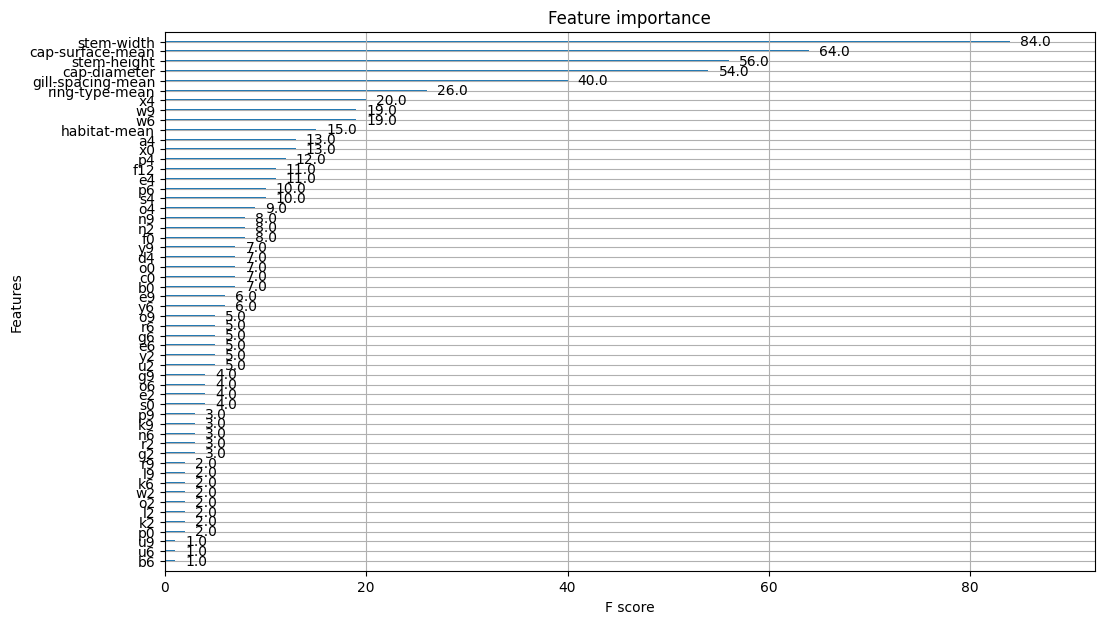

In [ ]:
plt.rcParams['figure.figsize'] = [12, 7]
xgb.plot_importance(model)

# Testeo del modelo con el set de testeo

La idea de esta sección es ver algunas métricas del modelo final.

In [ ]:
y_pred_test = model.predict(X_test)

In [ ]:
y_pred_test

array([1, 1, 1, ..., 0, 1, 1])

Realizo una matriz de confusión.

In [ ]:
matriz_confusion_test = confusion_matrix(y_test, y_pred_test)

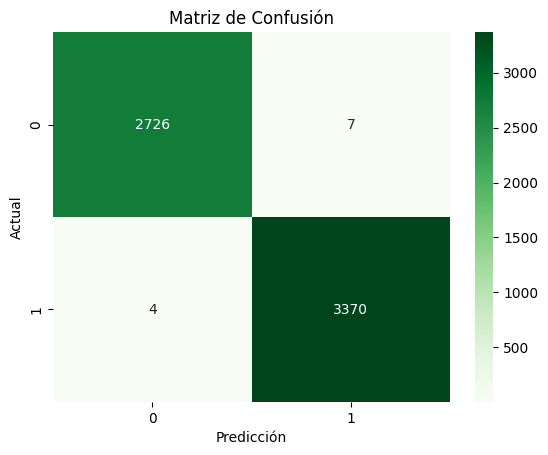

In [ ]:
sns.heatmap(matriz_confusion_test, annot=True, cmap='Greens', fmt='g')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.show()

Calculo de las metricas.

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE: %f" % (rmse))

RMSE: 0.042441


In [ ]:
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC AUC SCORE:", (roc_auc))

ROC AUC SCORE: 0.9999789613911161


Guardo las predicciones en un archivo.csv.

In [ ]:
df_predicciones = pd.DataFrame(y_test)

In [ ]:
df_predicciones.columns = ['Actual']

In [ ]:
df_predicciones["Prediccion"] = y_pred_test

In [ ]:
df_predicciones

,Actual,Prediccion
22594,1,1
60018,1,1
38408,1,1
43407,1,1
52538,0,0
...,...,...
53557,1,1
35871,1,1
51464,0,0
37312,1,1


In [ ]:
df_predicciones.to_csv('test.csv')

Se generar un archivo.csv en la notebook.